In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import signal
from IPython import display
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model

%matplotlib inline

In [17]:
cascade_path = './model/cv2/haarcascade_frontalface_alt2.xml'

In [18]:
image_dir_basepath = './face_data/'
names = ['PENRITE 更好的機油_1_Tony', 'PENRITE 更好的機油_2_Timmy', 'PENRITE 更好的機油_5_Kaylens', '人狼咧_3_Tim', '人狼咧_7_Sophie']
image_size = 160

In [19]:
model_path = './model/keras/facenet_keras.h5'
model = load_model(model_path)

C:\Users\shing\Anaconda3\envs\game\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [21]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [22]:
for name in names:
    dirpath = os.path.abspath(image_dir_basepath + name)
    filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:10]
    for filepath in filepaths:
        cascade = cv2.CascadeClassifier(cascade_path)
        img = imread(filepath)
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)

In [23]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [24]:
labels = []
embs = []
for name in names:
    dirpath = os.path.abspath(image_dir_basepath + name)
    filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:10]
    embs_ = calc_embs(filepaths)    
    labels.extend([name] * len(embs_))
    embs.append(embs_)

In [25]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [26]:
le, clf = train(image_dir_basepath, names)

In [27]:
def calc_embs_camera(imgs, margin, batch_size):
    aligned_images = prewhiten(imgs)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [28]:
class FaceDemo(object):
    def __init__(self, cascade_path):
        self.vc = None
        self.cascade = cv2.CascadeClassifier(cascade_path)
        self.margin = 10
        self.batch_size = 1
        self.n_img_per_person = 10
        self.is_interrupted = False
        self.data = {}
        self.le = le
        self.clf = clf
        
    def _signal_handler(self, signal, frame):
        self.is_interrupted = True
    
    def infer(self):
        list1=[]
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        while is_capturing:
            is_capturing, frame = vc.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            pred = None
            if len(faces) != 0:
                face = faces[0]
                (x, y, w, h) = face
                left = x - self.margin // 2
                right = x + w + self.margin // 2
                bottom = y - self.margin // 2
                top = y + h + self.margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                embs = calc_embs_camera(img[np.newaxis], self.margin, 1)
                pred = self.le.inverse_transform(self.clf.predict(embs))
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)
                
                if pred not in list1:
                    list1.append(pred)
                else:
                    pass
            plt.imshow(frame)
            plt.title(pred)
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            try:
                plt.pause(0.1)
            except Exception:
                pass
            if self.is_interrupted:
                vc.release()
                break

In [29]:
frame = cv2.imread('C:/Users/shing/project/image/210.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
print(frame.shape)

cascade = cv2.CascadeClassifier(cascade_path)
faces = cascade.detectMultiScale(frame,
                             scaleFactor=1.1,
                             minNeighbors=3,
                             minSize=(100, 100))
print(faces)

(720, 1280, 3)
[[504 144 322 322]]


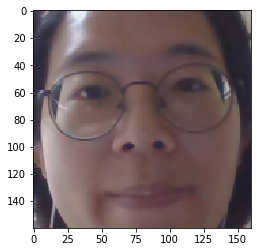

In [32]:
pred = None
face = faces[0]
(x, y, w, h) = face
left = x - 10 // 2
right = x + w + 10 // 2
bottom = y - 10 // 2
top = y + h + 10 // 2
img = resize(frame[bottom:top, left:right, :],
             (160, 160), mode='reflect')
plt.imshow(img)


In [31]:
print(img.shape)

(160, 160, 3)


In [33]:
print(img[np.newaxis].shape)

(1, 160, 160, 3)


In [34]:
aligned_images = prewhiten(img[np.newaxis])
print(aligned_images)

[[[[ 1.3509434   1.47258925  1.99840211]
   [-0.25683489 -0.21639406  0.40612613]
   [-0.98581285 -1.03078507 -0.31762822]
   ...
   [ 2.09151622  2.09151622  1.85834383]
   [ 2.18162915  2.18162915  1.94845676]
   [ 2.22627802  2.22627802  1.99310563]]

  [[-0.36844341 -0.24578653  0.21971118]
   [-1.13898252 -1.14518072 -0.53346297]
   [-0.88666905 -0.95723557 -0.26682669]
   ...
   [ 2.09151622  2.07924279  1.85834383]
   [ 2.19680358  2.19680358  1.96363118]
   [ 2.24210824  2.23251265  2.00893585]]

  [[-0.98622273 -0.90534105 -0.3739858 ]
   [-0.96987334 -0.96768734 -0.37917753]
   [-0.89839598 -0.93038887 -0.35679389]
   ...
   [ 2.05770167  2.01136321  1.81075298]
   [ 2.21903237  2.18114186  2.00138963]
   [ 2.22814067  2.22324496  2.01500653]]

  ...

  [[ 1.09730011  0.9409562   1.2814471 ]
   [ 0.88009001  0.69610242  1.04939047]
   [ 0.5214736   0.31460142  0.65525171]
   ...
   [ 1.08277238  0.79130689  0.8038308 ]
   [ 1.06813079  0.83263578  0.90891777]
   [ 1.10895873 

In [38]:
pd = []
for start in range(0, len(aligned_images), 1):
    pd.append(model.predict_on_batch(aligned_images[start:start+1]))
print(pd)

[array([[ 1.2124754 , -1.2063884 , -1.0497297 , -0.57397044, -0.23072454,
        -0.4922349 ,  0.17584682, -1.2470464 , -0.77177197, -0.8635424 ,
         0.38289592,  0.797026  ,  0.6005205 , -0.7851552 ,  0.31795195,
         1.0287544 ,  0.50412214, -0.34691352,  0.4060332 ,  0.2565127 ,
        -1.144719  ,  0.5780977 , -1.3898983 ,  0.0574303 ,  0.6176569 ,
         0.6866164 ,  0.6426642 ,  0.3069511 ,  0.9363932 ,  0.65519726,
         1.3896255 ,  1.1949251 ,  0.07472837, -0.9504863 , -0.44755423,
        -0.08945037, -0.93960017,  1.6212385 ,  1.5844526 ,  0.9975035 ,
         0.3201371 ,  1.2182562 ,  1.2003204 , -1.1966476 ,  0.30558118,
        -0.5355777 , -0.3177043 ,  0.21081755, -0.17869553,  1.1210318 ,
         0.08035102,  0.32791078,  1.0645844 ,  0.14269415,  0.74877244,
        -0.3495353 , -0.9703266 ,  0.5570293 ,  0.44551504, -0.3641192 ,
         0.14502245, -1.1134895 , -0.35601938,  0.5449756 ,  0.3834451 ,
         1.2939492 ,  0.95703655,  0.34789017, -0.

In [19]:
test_embs = calc_embs_camera(img[np.newaxis], 10, 1)
print(test_embs)

[[ 0.13479239 -0.13411568 -0.11669975 -0.063809   -0.02564993 -0.05472236
   0.01954911 -0.13863568 -0.08579884 -0.09600107  0.04256701  0.08860637
   0.06676061 -0.08728667  0.03534711  0.11436789  0.05604388 -0.03856681
   0.04513921  0.02851683 -0.12725982  0.06426784 -0.15451671  0.0063846
   0.06866568  0.076332    0.07144577  0.03412413  0.10409999  0.07283909
   0.15448639  0.1328413   0.00830765 -0.10566673 -0.04975516 -0.00994431
  -0.10445651  0.18023509  0.17614555  0.1108937   0.03559004  0.13543506
   0.1334411  -0.1330328   0.03397184 -0.05954084 -0.03531958  0.02343685
  -0.0198658   0.12462649  0.00893272  0.03645425  0.11835116  0.01586348
   0.08324196 -0.03885827 -0.10787241  0.06192564  0.04952846 -0.04047958
   0.01612233 -0.12378801 -0.03957912  0.06058561  0.04262807  0.14384994
   0.10639494  0.03867538 -0.09103448  0.06411478  0.02054087 -0.05568232
   0.00203135 -0.06456386 -0.03357634 -0.03629804 -0.06705879  0.09259021
  -0.09580494 -0.03109496 -0.06209099  

In [21]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

In [25]:
import scipy
from scipy.spatial import distance

clf_pred=clf.predict(test_embs)
clf_prob=clf.predict_proba(test_embs)[0]
pred = le.inverse_transform(clf_pred)

print(pred)


distance_list=[]
for n in range(3):
    distance_list.append(distance.euclidean(test_embs, data[pred[0]+str(n)]['emb']))

print(distance_list)
print(scipy.mean(distance_list))
    
if scipy.mean(distance_list) > 0.9:
    print('None')
else:
    print(pred)


['人狼咧_7_Sophie']
[0.7529051303863525, 0.7616544961929321, 1.2086328268051147]
0.9077308177947998
None


In [21]:
pred[0].split('_')

['PEN', '1', 'Tony']

In [16]:
f = FaceDemo(cascade_path)

C:\Users\shing\Anaconda3\envs\game\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21671 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 29436 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\shing\Anaconda3\envs\game\lib\site-packages\matplotlib\backends\backen

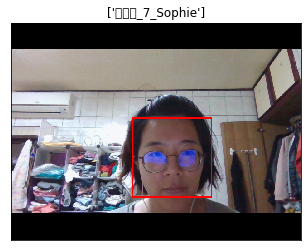

In [17]:
f.infer()

In [25]:
import scipy
from scipy.spatial import distance

class FaceDemo(object):
    def __init__(self, cascade_path):
        self.vc = None
        self.cascade = cv2.CascadeClassifier(cascade_path)
        self.margin = 10
        self.batch_size = 1
        self.n_img_per_person = 10
        self.is_interrupted = False
        self.data = {}
        self.le = le
        self.clf = clf
        
    def _signal_handler(self, signal, frame):
        self.is_interrupted = True
    
    def infer(self, frame):
        #frame = cv2.imread(input_image)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        faces = self.cascade.detectMultiScale(frame,
                                     scaleFactor=1.1,
                                     minNeighbors=3,
                                     minSize=(100, 100))
        pred = None
        if len(faces) != 0:
            face = faces[0]
            (x, y, w, h) = face
            left = x - self.margin // 2
            right = x + w + self.margin // 2
            bottom = y - self.margin // 2
            top = y + h + self.margin // 2
            img = resize(frame[bottom:top, left:right, :],
                         (160, 160), mode='reflect')
            new_embs = calc_embs_camera(img[np.newaxis], self.margin, 1)
            clf_pred=clf.predict(new_embs)
            clf_prob=clf.predict_proba(new_embs)[0]
            pred = le.inverse_transform(clf_pred)

            distance_list=[]
            for n in range(3):
                distance_list.append(distance.euclidean(new_embs, data[pred[0]+str(n)]['emb']))

            if scipy.mean(distance_list) < 0.9:
                cv2.rectangle(frame,
                          (left-1, bottom-1),
                          (right+1, top+1),
                          (255, 0, 0), thickness=2)
                
                result = pred
                
                
            else:
                result = 'Newplayer'
               
        else:
            result = 'None'
        return frame, result

In [27]:
f = FaceDemo(cascade_path)
vc = cv2.VideoCapture(0) #读入视频文件
rval , frame = vc.read()
img, result = f.infer(frame)
print(result)
vc.release()
cv2.destroyAllWindows()

Newplayer
